In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
from PIL import Image
from torchvision import transforms, datasets
import os
import shutil
import random
import csv
import zipfile
import PIL
import math
from IPython.display import clear_output

In [3]:
class Generator(nn.Module):
    def __init__(self, size_z, num_feature_maps, num_color_channels):
        super(Generator, self).__init__()
        self.size_z = size_z
        self.network = nn.Sequential(
            nn.ConvTranspose2d(self.size_z, num_feature_maps * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(num_feature_maps * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps * 4, num_feature_maps * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps * 2, num_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps, num_color_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        output = self.network(x)
        return output

    def gen_shifted(self, x, shift):
        shift = torch.unsqueeze(shift, -1)
        shift = torch.unsqueeze(shift, -1)
        return self.forward(x + shift)

In [4]:
class Discriminator(nn.Module):
    def __init__(self, num_feature_maps, num_color_channels):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(num_color_channels, num_feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(num_feature_maps, num_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(num_feature_maps * 2, num_feature_maps * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.fc = nn.Sequential(
            nn.Conv2d(num_feature_maps * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        feature = out
        out = self.fc(out)
        return out.view(-1, 1).squeeze(1), feature

In [5]:
class LatentSpaceMapper:
    def __init__(self, generator: Generator, discriminator: Discriminator, device):
        self.generator: Generator = generator
        self.generator.to(device)
        self.discriminator: Discriminator = discriminator
        self.discriminator.to(device)
        self.device = device

    def map_image_to_point_in_latent_space(self, image: torch.Tensor, batch_size=1, size_z=100, max_opt_iterations=30000, opt_threshold=140.0, plateu_threshold=3.0, check_every_n_iter=4000, learning_rate=0.4, print_every_n_iters=10000, ignore_rules_below_threshold=50, retry_after_n_iters=10000, immediate_retry_threshold=200):
        image.to(self.device)
        z = torch.randn(batch_size, size_z, 1, 1, device=self.device, requires_grad=True)
        z_optimizer = torch.optim.Adam([z], lr=learning_rate)
        losses = []
        final_loss = 0
        latest_checkpoint_loss = 0

        # scheduler = lr_scheduler.LinearLR(z_optimizer, start_factor=0.4, end_factor=0.001, total_iters=max_opt_iterations-(math.floor(max_opt_iterations*0.2)))
        # scheduler = lr_scheduler.StepLR(z_optimizer, step_size=max_opt_iterations, gamma=0.9)
        # scheduler = torch.optim.lr_scheduler.CyclicLR(z_optimizer, base_lr=0.01, max_lr=0.4, cycle_momentum=False)
        for i in range(max_opt_iterations):
            retry = False
            loss = self.__get_anomaly_score(z, image.unsqueeze(0).to(self.device))
            loss.backward()
            z_optimizer.step()
            final_loss = loss.data.item()

            if i == 1:
                latest_checkpoint_loss = loss.data.item()

            if loss.data.item() < opt_threshold*batch_size:
                print(f"Iteration: {i} -- Reached Defined Optimum -- Final Loss: {loss.data.item()}")
                break

            if (i % print_every_n_iters == 0 and i != 0) or (i == max_opt_iterations-1):
                print(f"Iteration: {i} -- Current Loss: {loss.data.item()} -- Current Learning-Rate: {z_optimizer.param_groups[0]['lr']}")
                losses.append(loss.data.item())

            if i % check_every_n_iter == 0 and i != 0:
                if abs(loss.data.item()-latest_checkpoint_loss) < plateu_threshold:
                    print(f"Reached Plateu at Iteration {i} -- Loss: {loss.data.item()}")
                    retry = True
                    break
                if loss.data.item() > immediate_retry_threshold:
                    print(f"Loss at Iteration {i} too high -- Loss: {loss.data.item()}")
                    retry = True
                    break
                latest_checkpoint_loss = loss.data.item()

            if i == retry_after_n_iters and loss.data.item() > ignore_rules_below_threshold:
                retry = True
                break

            #scheduler.step()

        return z, final_loss, retry

    def __get_anomaly_score(self, z, x_query):
        lamda = 0.1
        g_z = self.generator(z.to(self.device))
        loss_r = torch.sum(torch.abs(x_query - g_z))

        return loss_r

        #_, x_prop = self.discriminator(x_query)
        #_, g_z_prop = self.discriminator(g_z)
        #loss_d = torch.sum(torch.abs(x_prop - g_z_prop))
        #return (1 - lamda) * loss_r + lamda * loss_d


In [6]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset


class AnoMNIST(Dataset):
    def __init__(self, root_dir, transform=None):
        root_dir = os.path.join(root_dir, "AnoMNIST")
        assert os.path.exists(os.path.join(root_dir, "anomnist_dataset.csv")), "Invalid root directory"
        self.root_dir = root_dir
        self.transform = transform
        self.label = pd.read_csv(os.path.join(root_dir, "anomnist_dataset.csv"))

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.label.iloc[idx, 0])
        image_label = {"label": self.label.iloc[idx, 1], "anomaly": self.label.iloc[idx, 2]}
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image, image_label


class AnomalyExtendedMNIST(datasets.MNIST):
    def __getitem__(self, idx):
        return super(AnomalyExtendedMNIST, self).__getitem__(idx)[0], {"label": super(AnomalyExtendedMNIST, self).__getitem__(idx)[1], "anomaly": False}


In [7]:
def generate_augmented_mnist_images(base_folder, num, max_augmentation_thickness=5,
                                    randomize_augmentation_thickness=False, labels=[]):
    assert max_augmentation_thickness <= 7, "max_augmentation_thickness must be smaller than 7"
    os.makedirs(base_folder, exist_ok=True)

    dataset = datasets.MNIST(
        root=base_folder,
        train=True,
        download=True,
    )

    if len(labels) > 0:
        dataset = [d for d in dataset if (d[1] in labels)]
    else:
        dataset = dataset.data

    ano_mnist_drop_folder = os.path.join(base_folder, "AnoMNIST")
    csv_path = os.path.join(ano_mnist_drop_folder, "anomnist_dataset.csv")

    os.makedirs(base_folder, exist_ok=True)
    os.makedirs(ano_mnist_drop_folder, exist_ok=True)

    augmentation_thickness: int = random.randint(1, max_augmentation_thickness)
    for i in range(num):
        random_idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[random_idx]

        augmentation_thickness = random.randint(3,
                                                max_augmentation_thickness) if randomize_augmentation_thickness else augmentation_thickness
        random_idx = random.randint(4, 20)
        for j in range(img.size[0]):
            for k in range(augmentation_thickness):
                img.putpixel((j, random_idx + k + 1), 0)

        img.save(os.path.join(ano_mnist_drop_folder, f"img_aug_{label}_{i}.png"))
        with open(csv_path, 'a', newline='') as file:
            writer = csv.writer(file)
            fields = [f'img_aug_{label}_{i}.png', f"{label}", "True"]
            writer.writerow(fields)


def generate_anomalous_image_files(base_folder, num, labels=[], copy_zip_to=''):
    if os.path.exists(base_folder):
        shutil.rmtree(base_folder)

    ano_mnist_drop_folder = os.path.join(base_folder, "AnoMNIST")
    csv_path = os.path.join(ano_mnist_drop_folder, "anomnist_dataset.csv")

    os.makedirs(base_folder, exist_ok=True)
    os.makedirs(ano_mnist_drop_folder, exist_ok=True)

    with open(csv_path, 'a', newline='') as file:
        writer = csv.writer(file)
        fields = ["filename", "label", "anomaly"]
        writer.writerow(fields)

    generate_augmented_mnist_images(base_folder, num=num, labels=labels)
    if copy_zip_to:
      shutil.make_archive(os.path.join(copy_zip_to, "AnoMNIST"), 'zip', ano_mnist_drop_folder)

def get_ano_mnist_dataset(transform, root_dir, labels=[9], train_size=0.9):
    ano_mnist_dataset = AnoMNIST(
        root_dir=root_dir,
        transform=transform
    )

    mnist_dataset = AnomalyExtendedMNIST(
        root=root_dir,
        train=True,
        transform=transform,
        download=True,
    )

    dat = torch.utils.data.ConcatDataset([ano_mnist_dataset, mnist_dataset])

    if len(labels) > 0:
        dat = [d for d in dat if (d[1]['label'] in labels)]

    absolute_train_size = int(len(dat) * train_size)
    absolute_test_size = len(dat) - absolute_train_size
    return torch.utils.data.random_split(dat, [absolute_train_size, absolute_test_size])

In [8]:
def load_ano_mnist_from_drive(drop_folder):
  with zipfile.ZipFile('/content/drive/MyDrive/Colab/data/AnoMNIST.zip', 'r') as zip_ref:
    zip_ref.extractall(drop_folder)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_color_channels = 1
num_feature_maps_g = 64
num_feature_maps_d = 64
size_z = 100

device

device(type='cuda')

In [10]:
generator = Generator(size_z=size_z,
                      num_feature_maps=num_feature_maps_g,
                      num_color_channels=num_color_channels).to(device)
discriminator = Discriminator(num_feature_maps=num_feature_maps_d,
                              num_color_channels=num_color_channels).to(device)

generator.load_state_dict(torch.load("/content/drive/MyDrive/Colab/saved_models/generator.pkl", map_location=torch.device(device)))
discriminator.load_state_dict(torch.load('/content/drive/MyDrive/Colab/saved_models/discriminator.pkl', map_location=torch.device(device)))

<All keys matched successfully>

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(.5,), std=(.5,))
])

# generate_anomalous_image_files(base_folder='/content/data', num=2000, labels=[9]) # number of normals is: 5949
load_ano_mnist_from_drive(drop_folder='/content/data')
ano_mnist_dataset, _ = get_ano_mnist_dataset(transform=transform, root_dir='/content/data', labels=[9])

100%|██████████| 9912422/9912422 [00:00<00:00, 138383664.00it/s]

Extracting /content/data/AnomalyExtendedMNIST/raw/train-images-idx3-ubyte.gz to /content/data/AnomalyExtendedMNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 23498679.69it/s]


Extracting /content/data/AnomalyExtendedMNIST/raw/train-labels-idx1-ubyte.gz to /content/data/AnomalyExtendedMNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 70306312.99it/s]

Extracting /content/data/AnomalyExtendedMNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/AnomalyExtendedMNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3124574.18it/s]


Extracting /content/data/AnomalyExtendedMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/AnomalyExtendedMNIST/raw



Cleared Output...
6954 images left
Iteration: 721 -- Reached Defined Optimum -- Final Loss: 54.99495315551758
Original Image


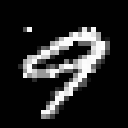

Mapped and Reconstructed Image


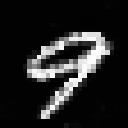

-----------------------
6953 images left
Iteration: 42 -- Reached Defined Optimum -- Final Loss: 53.605709075927734
Original Image


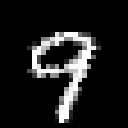

Mapped and Reconstructed Image


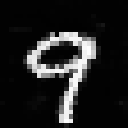

-----------------------
6952 images left
Iteration: 4576 -- Reached Defined Optimum -- Final Loss: 39.99968719482422
Original Image


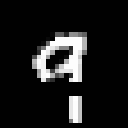

Mapped and Reconstructed Image


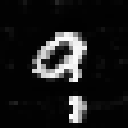

-----------------------
6951 images left
Iteration: 267 -- Reached Defined Optimum -- Final Loss: 54.990909576416016
Original Image


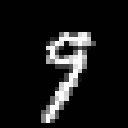

Mapped and Reconstructed Image


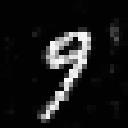

-----------------------
6950 images left
Iteration: 107 -- Reached Defined Optimum -- Final Loss: 54.85802459716797
Original Image


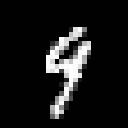

Mapped and Reconstructed Image


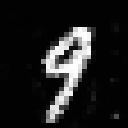

-----------------------
6949 images left
Iteration: 124 -- Reached Defined Optimum -- Final Loss: 54.648780822753906
Original Image


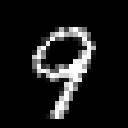

Mapped and Reconstructed Image


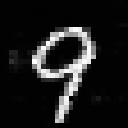

-----------------------
6948 images left
Iteration: 107 -- Reached Defined Optimum -- Final Loss: 54.69684600830078
Original Image


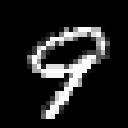

Mapped and Reconstructed Image


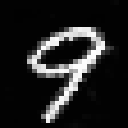

-----------------------
6947 images left
Loss at Iteration 3000 too high -- Loss: 70.910888671875
Could not find optimal region within the defined iteration count. Retry (1) with another random z...
6947 images left
Loss at Iteration 3000 too high -- Loss: 69.05314636230469
Could not find optimal region within the defined iteration count. Retry (2) with another random z...
6947 images left
Loss at Iteration 3000 too high -- Loss: 67.50787353515625
Could not find optimal region within the defined iteration count. Retry (3) with another random z...
6947 images left
Loss at Iteration 3000 too high -- Loss: 65.92596435546875
Could not find optimal region within the defined iteration count. Retry (4) with another random z...
6947 images left
Loss at Iteration 3000 too high -- Loss: 81.40580749511719
Could not find optimal region within the defined iteration count. Retry (5) with another random z...
6947 images left
Loss at Iteration 3000 too high -- Loss: 66.76104736328125
Could not find op

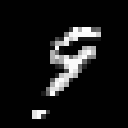

-----------------------
6946 images left
Iteration: 5000 -- Current Loss: 46.0934944152832 -- Current Learning-Rate: 0.1
Iteration: 10000 -- Current Loss: 45.44816589355469 -- Current Learning-Rate: 0.1
Iteration: 15000 -- Current Loss: 45.11738967895508 -- Current Learning-Rate: 0.1
Iteration: 20000 -- Current Loss: 44.76116943359375 -- Current Learning-Rate: 0.1
Iteration: 25000 -- Current Loss: 44.39427185058594 -- Current Learning-Rate: 0.1
Iteration: 29999 -- Current Loss: 44.17369079589844 -- Current Learning-Rate: 0.1
Original Image


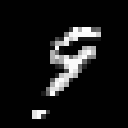

Mapped and Reconstructed Image


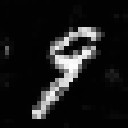

-----------------------
6945 images left
Iteration: 343 -- Reached Defined Optimum -- Final Loss: 54.97621154785156
Original Image


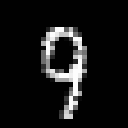

Mapped and Reconstructed Image


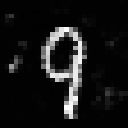

-----------------------
6944 images left
Loss at Iteration 3000 too high -- Loss: 69.3311767578125
Could not find optimal region within the defined iteration count. Retry (1) with another random z...
6944 images left
Loss at Iteration 3000 too high -- Loss: 66.12588500976562
Could not find optimal region within the defined iteration count. Retry (2) with another random z...
6944 images left
Loss at Iteration 3000 too high -- Loss: 64.9281005859375
Could not find optimal region within the defined iteration count. Retry (3) with another random z...
6944 images left
Iteration: 5000 -- Current Loss: 58.04265213012695 -- Current Learning-Rate: 0.1
Iteration: 10000 -- Current Loss: 57.145408630371094 -- Current Learning-Rate: 0.1
Could not find optimal region within the defined iteration count. Retry (4) with another random z...
6944 images left
Loss at Iteration 3000 too high -- Loss: 70.63221740722656
Could not find optimal region within the defined iteration count. Retry (5) with another 

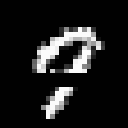

Mapped and Reconstructed Image


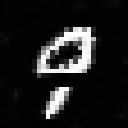

-----------------------
6943 images left
Loss at Iteration 3000 too high -- Loss: 69.37592315673828
Could not find optimal region within the defined iteration count. Retry (1) with another random z...
6943 images left
Iteration: 338 -- Reached Defined Optimum -- Final Loss: 39.9852409362793
Original Image


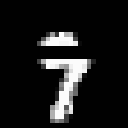

Mapped and Reconstructed Image


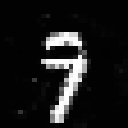

-----------------------
6942 images left
Loss at Iteration 3000 too high -- Loss: 122.19180297851562
Could not find optimal region within the defined iteration count. Retry (1) with another random z...
6942 images left
Iteration: 5000 -- Current Loss: 55.40384292602539 -- Current Learning-Rate: 0.1
Iteration: 8384 -- Reached Defined Optimum -- Final Loss: 54.99981689453125
Original Image


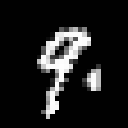

Mapped and Reconstructed Image


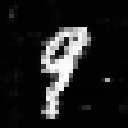

-----------------------
6941 images left
Iteration: 1346 -- Reached Defined Optimum -- Final Loss: 39.998992919921875
Original Image


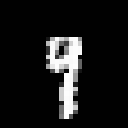

Mapped and Reconstructed Image


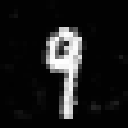

-----------------------
6940 images left


In [ ]:
from torch.cuda import reset_max_memory_allocated
def create_cp(iteration_number):
  print("CREATING CHECKPOINT...")
  drive.mount('/content/drive', force_remount=True)
  shutil.make_archive(f"/content/drive/MyDrive/Colab/data/latent_space_mappings_cp/latent_space_mappings_cp{iteration_number}", 'zip', "/content/data/latent_space_mappings")

def save_to_drive(mapped_z, iteration_number, csv_path):
  torch.save(mapped_z, f'/content/drive/MyDrive/Colab/data/latent_space_mappings/mapped_z_{iteration_number}.pt')
  shutil.copy(csv_path, "/content/drive/MyDrive/Colab/data/latent_space_mappings/latent_space_mappings.csv")

base_folder = "/content/data/latent_space_mappings"
csv_path = os.path.join(base_folder, "latent_space_mappings.csv")


prepare_target_folder = True
if prepare_target_folder:
    if not os.path.exists(base_folder):
        os.mkdir(base_folder)

    if os.path.exists(base_folder):
        shutil.rmtree(base_folder)
        os.mkdir(base_folder)

    with open(csv_path, 'a', newline='') as file:
        writer = csv.writer(file)
        fields = ["filename", "label", "anomaly", "reconstruction_loss"]
        writer.writerow(fields)

# Start mapping
map_anomalies = True
map_normals = True
t = transforms.ToPILImage()
lsm: LatentSpaceMapper = LatentSpaceMapper(generator=generator, discriminator=discriminator, device=device)
mapped_images = []
cp_counter = 0
counter = len(ano_mnist_dataset)

i = 0
retry_counter = 0
while i < len(ano_mnist_dataset):
    if i % 50 == 0 and i != 0:
        clear_output()
        print("Cleared Output...")

    print(f"{counter} images left")

    if ano_mnist_dataset[i][1]["anomaly"] == True:
        max_retries = 20
        opt_threshold=40
        ignore_rules_below_threshold=50
        immediate_retry_threshold=60
        max_opt_iterations=30000
    else:
        max_retries = 5
        opt_threshold=55
        ignore_rules_below_threshold=60
        immediate_retry_threshold=65
        max_opt_iterations=20000

    if (ano_mnist_dataset[i][1]["anomaly"] == True and map_anomalies) or (ano_mnist_dataset[i][1]["anomaly"] == False and map_normals):
        mapped_z, reconstruction_loss, retry = lsm.map_image_to_point_in_latent_space(ano_mnist_dataset[i][0],
                                                                               batch_size=1,
                                                                               max_opt_iterations=max_opt_iterations,
                                                                               plateu_threshold=0.0005,
                                                                               check_every_n_iter=3000,
                                                                               learning_rate=0.1,
                                                                               print_every_n_iters=5000,
                                                                               retry_after_n_iters=10000,
                                                                               ignore_rules_below_threshold=ignore_rules_below_threshold,
                                                                               opt_threshold=opt_threshold,
                                                                               immediate_retry_threshold=immediate_retry_threshold)

        if retry:
            if retry_counter == max_retries:
                retry_counter = 0
                i+=1
                counter-=1
                print("Retry Limit reached. Moving on to next sample")
                print('Original Image That Could Not Be Mapped')
                t(ano_mnist_dataset[i][0]).resize((128, 128), PIL.Image.NEAREST).show()
                print('-----------------------')
                continue
            else:
                retry_counter += 1
                print(f"Could not find optimal region within the defined iteration count. Retry ({retry_counter}) with another random z...")
                continue

        retry_counter = 0
        mapped_images.append(mapped_z)
        with open(csv_path, 'a', newline='') as file:
            writer = csv.writer(file)
            fields = [f'mapped_z_{counter}.pt', ano_mnist_dataset[i][1]["label"], ano_mnist_dataset[i][1]["anomaly"], math.floor(reconstruction_loss)]
            writer.writerow(fields)

        torch.save(mapped_z, os.path.join(base_folder, f'mapped_z_{counter}.pt'))
        save_to_drive(mapped_z, counter, csv_path)
        cp_counter += 1
        if cp_counter % 50 == 0:
          create_cp(counter)
          clear_output

        print('Original Image')
        t(ano_mnist_dataset[i][0]).resize((128, 128), PIL.Image.NEAREST).show()
        print('Mapped and Reconstructed Image')
        original_img = generator(mapped_z).cpu()
        img = t(original_img[0]).resize((128, 128), PIL.Image.NEAREST)
        img.show()
        print('-----------------------')

    i+=1
    counter-=1

create_cp(0)